In [73]:
# import os
# import time
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import random
# from keras import layers, optimizers, losses, datasets, Model

# # Конфигурация
# BUFFER_SIZE = 100000
# EPOCHS = 100
# BATCH_SIZE = 32
# NOISE_DIM = 100

# # Подготовка данных
# (train_images, _), (_, _) = datasets.mnist.load_data()
# train_images = train_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# # Генератор
# class Generator(Model):
#     def __init__(self):
#         super().__init__()
#         self.dense = layers.Dense(7*7*256, use_bias=False)
#         self.bn1 = layers.BatchNormalization()
#         self.relu = layers.ReLU()
#         self.reshape = layers.Reshape((7, 7, 256))
        
#         self.convT1 = layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False)
#         self.bn2 = layers.BatchNormalization()
#         self.convT2 = layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False)
#         self.bn3 = layers.BatchNormalization()
#         self.convT3 = layers.Conv2DTranspose(1, 5, strides=2, padding='same', activation='sigmoid')

#     def call(self, inputs, training=False):
#         x = self.dense(inputs)
#         x = self.bn1(x, training=training)
#         x = self.relu(x)
#         x = self.reshape(x)
        
#         x = self.convT1(x)
#         x = self.bn2(x, training=training)
#         x = self.relu(x)
        
#         x = self.convT2(x)
#         x = self.bn3(x, training=training)
#         x = self.relu(x)
        
#         return self.convT3(x)

# # Дискриминатор
# class Discriminator(Model):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = layers.Conv2D(64, 5, strides=2, padding='same')
#         self.leaky_relu1 = layers.LeakyReLU(0.2)
#         self.dropout1 = layers.Dropout(0.3)
        
#         self.conv2 = layers.Conv2D(128, 5, strides=2, padding='same')
#         self.leaky_relu2 = layers.LeakyReLU(0.2)
#         self.dropout2 = layers.Dropout(0.3)
        
#         self.flatten = layers.Flatten()
#         self.dense = layers.Dense(1)

#     def call(self, inputs, training=False):
#         x = self.conv1(inputs)
#         x = self.leaky_relu1(x)
#         x = self.dropout1(x, training=training)
        
#         x = self.conv2(x)
#         x = self.leaky_relu2(x)
#         x = self.dropout2(x, training=training)
        
#         x = self.flatten(x)
#         return self.dense(x)

# # Полный GAN
# class GAN(Model):
#     def __init__(self, generator, discriminator):
#         super().__init__()
#         self.generator = generator
#         self.discriminator = discriminator
#         self.noise_dim = NOISE_DIM
#         self.seed = random.normal([16, NOISE_DIM])

#     def compile(self, g_optimizer, d_optimizer, loss_fn):
#         super().compile()
#         self.g_optimizer = g_optimizer
#         self.d_optimizer = d_optimizer
#         self.loss_fn = loss_fn
#         self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
#         self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")

#     @property
#     def metrics(self):
#         return [self.g_loss_metric, self.d_loss_metric]

#     def train_step(self, real_images):
#         batch_size = tf.shape(real_images)[0]
#         noise = random.normal([batch_size, self.noise_dim])

#         # Обновление дискриминатора
#         with tf.GradientTape() as d_tape:
#             fake_images = self.generator(noise, training=False)
            
#             real_output = self.discriminator(real_images, training=True)
#             fake_output = self.discriminator(fake_images, training=True)
            
#             d_loss = self.loss_fn.discriminator_loss(real_output, fake_output)
        
#         d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
#         self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))

#         # Обновление генератора
#         with tf.GradientTape() as g_tape:
#             fake_images = self.generator(noise, training=True)
#             fake_output = self.discriminator(fake_images, training=False)
            
#             g_loss = self.loss_fn.generator_loss(fake_output)
        
#         g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
#         self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))

#         # Обновление метрик
#         self.g_loss_metric.update_state(g_loss)
#         self.d_loss_metric.update_state(d_loss)
        
#         return {
#             "g_loss": self.g_loss_metric.result(),
#             "d_loss": self.d_loss_metric.result()
#         }

#     def generate_images(self):
#         return self.generator(self.seed, training=False)

# # Функции потерь
# class GANLoss:
#     def __init__(self):
#         self.bce = losses.BinaryCrossentropy(from_logits=True)
    
#     def discriminator_loss(self, real_output, fake_output):
#         real_loss = self.bce(tf.ones_like(real_output), real_output)
#         fake_loss = self.bce(tf.zeros_like(fake_output), fake_output)
#         return real_loss + fake_loss
    
#     def generator_loss(self, fake_output):
#         return self.bce(tf.ones_like(fake_output), fake_output)

# # Коллбэк для генерации изображений
# class ImageCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         noise = random.normal([16, NOISE_DIM])
#         images = self.model.generator(noise, training=False)
        
#         plt.figure(figsize=(7,7))
#         for i in range(16):
#             plt.subplot(4,4,i+1)
#             plt.imshow(images[i].numpy()[:,:,0] * 255, cmap='gray')
#             plt.axis('off')
#         plt.show()

# # Инициализация компонентов
# generator = Generator()
# discriminator = Discriminator()

# # Форсируем построение моделей
# generator.build(input_shape=(None, NOISE_DIM))
# discriminator.build(input_shape=(None, 28, 28, 1))

# loss_fn = GANLoss()

# gan = GAN(generator, discriminator)

# # Дополнительная инициализация весов
# gan.generator.predict(tf.random.normal([1, NOISE_DIM]))  # Форсирует построение
# gan.discriminator.predict(tf.zeros([1, 28, 28, 1]))      # Форсирует построение

# gan.compile(
#     g_optimizer=optimizers.Adam(1e-4),
#     d_optimizer=optimizers.Adam(1e-4),
#     loss_fn=loss_fn
# )

# # Обучение модели
# history = gan.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     callbacks=[
#         ImageGeneratorCallback(),
#         tf.keras.callbacks.ModelCheckpoint(
#             'gan_checkpoints/ckpt_{epoch}.weights.h5',
#             save_weights_only=True,
#             save_freq=5*len(train_dataset)
#         )
#     ]
# )

# # Сохранение моделей
# generator.save("generator.keras")
# discriminator.save("discriminator.keras")

# # Пример генерации
# noise = random.normal([1, NOISE_DIM])
# generated_image = generator(noise)
# plt.imshow(generated_image[0,:,:,0], cmap='gray')
# plt.show()

# Imports

In [74]:
import os
import time

In [75]:
from IPython import display
import matplotlib.pyplot as plt

In [76]:
import tensorflow as tf
from tensorflow import random
from keras import layers, optimizers, losses, datasets, Model, Input, metrics, callbacks
from keras.src.utils import file_utils

# Params

In [77]:
BUFFER_SIZE = 100000
EPOCHS = 100
BATCH_SIZE = 2**5
NOISE_DIM = int(10e1)

# Data preparation

In [78]:
# Подготовка данных
(train_images, _), (_, _) = datasets.mnist.load_data()
train_images = train_images.reshape(-1, 28, 28, 1).astype("float32") / 255.0
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

# Generator

In [79]:
class Generator(Model):
    def __init__(self):
        super().__init__()
        self.dense = layers.Dense(7 * 7 * 256, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.reshape = layers.Reshape((7, 7, 256))

        self.convT1 = layers.Conv2DTranspose(
            128, 5, strides=1, padding="same", use_bias=False
        )
        self.bn2 = layers.BatchNormalization()
        self.convT2 = layers.Conv2DTranspose(
            64, 5, strides=2, padding="same", use_bias=False
        )
        self.bn3 = layers.BatchNormalization()
        self.convT3 = layers.Conv2DTranspose(
            1, 5, strides=2, padding="same", activation="sigmoid"
        )

    def call(self, inputs, training=False):
        x = self.dense(inputs)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.reshape(x)

        x = self.convT1(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)

        x = self.convT2(x)
        x = self.bn3(x, training=training)
        x = self.relu(x)

        return self.convT3(x)

    # def build(self, img_shape):
    #     # Метод для явной инициализации и проверки архитектуры
    #     x = Input(shape=img_shape)
    #     return Model(inputs=[x], outputs=self.call(x))

In [80]:
img_shape = list(train_images.shape[1:])
img_shape[-1] = 7 * 7 * 256

In [81]:
generator = Generator()

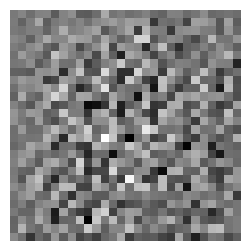

In [82]:
def draw_image(image):

    plt.figure(figsize=(3, 3))
    plt.imshow(image[0, :, :, 0], cmap="gray")
    plt.axis("off")
    plt.show()


noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)
draw_image(generated_image)

# Discriminator

In [83]:
class Discriminator(Model):
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(64, 5, strides=2, padding="same")
        self.leaky_relu1 = layers.LeakyReLU(0.2)
        self.dropout1 = layers.Dropout(0.3)

        self.conv2 = layers.Conv2D(128, 5, strides=2, padding="same")
        self.leaky_relu2 = layers.LeakyReLU(0.2)
        self.dropout2 = layers.Dropout(0.3)

        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.leaky_relu1(x)
        x = self.dropout1(x, training=training)

        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x, training=training)

        x = self.flatten(x)
        return self.dense(x)

    # def build(self, img_shape):
    #     # Метод для явной инициализации и проверки архитектуры
    #     x = Input(shape=img_shape)
    #     return Model(inputs=[x], outputs=self.call(x))

In [84]:
discriminator = Discriminator()


In [85]:
discriminator(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.05960084]], dtype=float32)>

# GAN

In [ ]:
class GAN(Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.noise_dim = NOISE_DIM
        self.seed = random.normal([16, NOISE_DIM])

        # Инициализация метрик в конструкторе
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.d_loss_metric = metrics.Mean(name="d_loss")

    def compile(
        self,
        g_optimizer: optimizers.Optimizer,
        d_optimizer: optimizers.Optimizer,
        loss_fn,
    ):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        noise = random.normal([batch_size, self.noise_dim])

        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            # Генерация изображений
            fake_images = self.generator(noise, training=True)

            # Оценка дискриминатора
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(fake_images, training=True)

            # Вычисление потерь
            d_loss = self.loss_fn.discriminator_loss(real_output, fake_output)
            g_loss = self.loss_fn.generator_loss(fake_output)

        # Обновление дискриминатора
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(d_grads, self.discriminator.trainable_weights)
        )

        # Обновление генератора
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))

        # Обновление метрик
        self.g_loss_metric.update_state(g_loss)
        self.d_loss_metric.update_state(d_loss)

        return {
            "g_loss": self.g_loss_metric.result(),
            "d_loss": self.d_loss_metric.result(),
        }


# Функции потерь
class GANLoss:
    def __init__(self):
        self.bce = losses.BinaryCrossentropy(from_logits=True)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.bce(tf.ones_like(real_output), real_output)
        fake_loss = self.bce(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def generator_loss(self, fake_output):
        return self.bce(tf.ones_like(fake_output), fake_output)


# Коллбэк для генерации изображений
class ImageCallback(callbacks.Callback):
    def __init__(self, filepath: str, save_freq: str | int = "epoch"):
        super().__init__()
        self.filepath: str = file_utils.path_to_string(filepath)
        self.save_freq: str | int = save_freq
        self._epoches_seen_since_last_saving = 0

        if self.save_freq != "epoch" and not isinstance(self.save_freq, int):
            raise ValueError(
                f"Unrecognized save_freq: {self.save_freq}. "
                "Expected save_freq are 'epoch' or integer values"
            )

        if not self.filepath.endswith((".png", ".jpg")):
            raise ValueError(
                "Wrong image filepath extension!"
                "Received: "
                f"filepath={self.filepath}"
            )

    def on_epoch_end(self, epoch: int, logs=None):
        noise = random.normal([16, NOISE_DIM])
        images = self.model.generator(noise, training=False)
        
        print(f"Epoch {epoch}/{EPOCHS}")
        
        display.clear_output(wait=True)

        plt.figure(figsize=(7, 7))
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy()[:, :, 0] * 255, cmap="gray")
            plt.axis("off")

        if self._should_save_on_epoch():
            plt.savefig(self._get_file_path(epoch))

        plt.show()

    def _should_save_on_epoch(self):
        if self.save_freq == "epoch":
            return True

        self._epoches_seen_since_last_saving += 1

        if self._epoches_seen_since_last_saving >= self.save_freq:
            self._epoches_seen_since_last_saving = 0
            return True
        return False

    def _get_file_path(self, epoch):
        return self.filepath.format(epoch=epoch + 1)

# Train

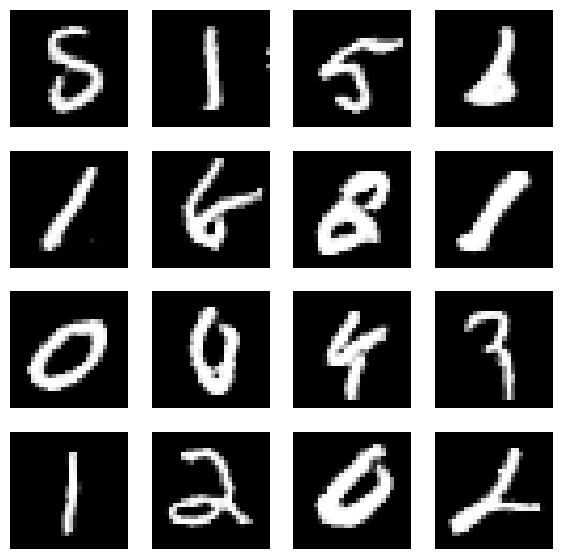

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 116s 62ms/step - d_loss: 1.3448 - g_loss: 0.7612


FileNotFoundError: [Errno 2] No such file or directory: 'gan_models/generator.keras'

In [ ]:
# Инициализация и обучение
gan = GAN(generator, discriminator)
gan.compile(
    g_optimizer=optimizers.Adam(1e-4),
    d_optimizer=optimizers.Adam(1e-4),
    loss_fn=GANLoss(),
)

gan.build((None, 28, 28, 1))

history = gan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[
        ImageCallback("gan_images/{epoch}.png", save_freq=1),
        callbacks.ModelCheckpoint(
            "gan_checkpoints/ckpt_{epoch}.keras",
            # save_weights_only=True,
            save_freq=5 * len(train_dataset),
        ),
    ],
)

In [88]:
gan.save("gan_models/gan.keras")
# Сохранение моделей
generator.save("gan_models/generator.keras")
discriminator.save("gan_models/discriminator.keras")

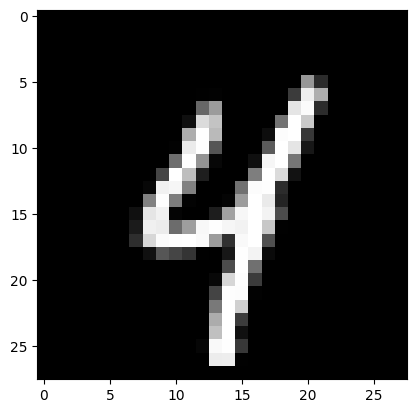

In [94]:
noise = random.normal([1, NOISE_DIM])
generated_image = gan.generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")
plt.show()